# Filter viral barcodes in transcripts
This notebook filters viral barcodes in 10X transcriptome data to remove UMIs that are likely derived from leaked transcripts.

### Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import kneed

import numpy

import pandas as pd

import plotnine as p9

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial2_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_by_cell_corrected_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_corrected.csv.gz'
expt = 'scProgenyProduction_trial2'

### Organize data

Read the viral barcode UMI counts data into a pandas dataframe:

In [3]:
viral_bc_counts = pd.read_csv(viral_bc_by_cell_corrected_csv)
viral_bc_counts = (viral_bc_counts
                   .rename(columns={'count': 'bc_UMIs'}))
display(viral_bc_counts)

,cell_barcode,gene,viral_barcode,bc_UMIs
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12
...,...,...,...,...
55238,TTTGTTGCATGTGGTT,fluNA,TTCCTCAGCCTTTAAG,3
55239,TTTGTTGTCTAGGAAA,fluNA,GAACCCGATGGGGAAT,26
55240,TTTGTTGTCTAGGAAA,fluNA,TAAGGTAAAATAATAG,1
55241,TTTGTTGTCTAGGAAA,fluNA,TAAGGTATAATTCTAG,4


Read the total number of UMIs per cell into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                             'infected',
                             'infecting_viral_tag',
                             'total_UMIs',
                             'viral_UMIs',
                             'cellular_UMIs',
                             'frac_viral_UMIs']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901
1,AAACCCACAAGGCCTC,True,syn,10304,1485,8819,0.144119
2,AAACCCACACACACGC,True,both,7395,3320,4075,0.448952
3,AAACCCATCGTGCATA,True,syn,2764,1597,1167,0.577786
4,AAACCCATCTACTGCC,False,none,6313,3,6310,0.000475
...,...,...,...,...,...,...,...
7436,TTTGGTTGTTAAGCAA,False,none,8528,29,8499,0.003401
7437,TTTGGTTTCGTCGCTT,False,none,6492,6,6486,0.000924
7438,TTTGTTGCATGTGGTT,True,wt,3016,1680,1336,0.557029
7439,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181


Sanity check that `total_UMIs` is equal to `viral_UMIs + cellular_UMIs`:

In [5]:
assert bool((all_cells['total_UMIs'] ==
             all_cells['viral_UMIs'] +
             all_cells['cellular_UMIs'])
            .all()), "UMI counts do not add up"

Merge dataframes:

In [6]:
viral_bc_frac = pd.merge(viral_bc_counts,
                         all_cells,
                         on=['cell_barcode'])

# Make `infecting_viral_tag` column ordered category
viral_bc_frac['infecting_viral_tag'] = (viral_bc_frac['infecting_viral_tag']
                                        .astype('category')
                                        .cat
                                        .reorder_categories(['none',
                                                             'wt',
                                                             'syn',
                                                             'both']))
display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1,True,syn,5367,3166,2201,0.589901
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14,True,syn,5367,3166,2201,0.589901
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8,True,syn,5367,3166,2201,0.589901
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5,True,syn,5367,3166,2201,0.589901
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12,True,syn,5367,3166,2201,0.589901
...,...,...,...,...,...,...,...,...,...,...
55238,TTGGATGGTGCACGCT,fluNA,GCATTTCCTCTCGCTT,1,False,none,5179,12,5167,0.002317
55239,TTGTGGAGTCTGTCCT,fluNA,AACACCTAATGGGGGT,1,False,none,6077,7,6070,0.001152
55240,TTGTTTGCAAGGACAC,fluNA,TTGTGTTTTACGAAAT,1,False,none,7249,5,7244,0.000690
55241,TTTATGCAGAGTCGAC,fluNA,GGTATTATGTGAAGGA,1,False,none,7223,4,7219,0.000554


Calculate each barcode's fraction of all UMIs per cell:

In [7]:
viral_bc_frac['bc_frac'] = (viral_bc_frac['bc_UMIs'] /
                            viral_bc_frac['total_UMIs'])

display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,bc_frac
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1,True,syn,5367,3166,2201,0.589901,0.000186
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14,True,syn,5367,3166,2201,0.589901,0.002609
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8,True,syn,5367,3166,2201,0.589901,0.001491
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5,True,syn,5367,3166,2201,0.589901,0.000932
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12,True,syn,5367,3166,2201,0.589901,0.002236
...,...,...,...,...,...,...,...,...,...,...,...
55238,TTGGATGGTGCACGCT,fluNA,GCATTTCCTCTCGCTT,1,False,none,5179,12,5167,0.002317,0.000193
55239,TTGTGGAGTCTGTCCT,fluNA,AACACCTAATGGGGGT,1,False,none,6077,7,6070,0.001152,0.000165
55240,TTGTTTGCAAGGACAC,fluNA,TTGTGTTTTACGAAAT,1,False,none,7249,5,7244,0.000690,0.000138
55241,TTTATGCAGAGTCGAC,fluNA,GGTATTATGTGAAGGA,1,False,none,7223,4,7219,0.000554,0.000138


### Plots
Set base plot style:

In [8]:
p9.theme_set(p9.theme_classic())

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 189 rows containing missing values.


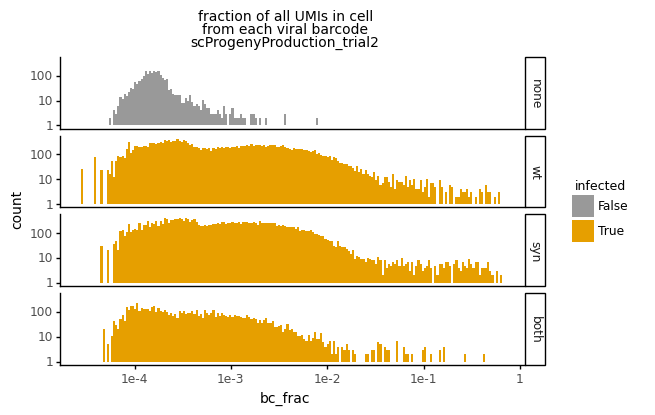

<ggplot: (8745505875884)>

In [16]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='bc_frac',
                                       fill='infected')) +
       p9.geom_histogram(bins=200, position='stack') +
       p9.facet_grid('infecting_viral_tag~') +
       p9.ggtitle('fraction of all UMIs in cell\n'
                  'from each viral barcode\n'
                  f'{expt}') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(5,
                             1*viral_bc_frac['infecting_viral_tag'].nunique()),
        plot_title=p9.element_text(size=10),
        axis_title=p9.element_text(size=10),
        legend_title=p9.element_text(size=9),
        legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

In [ ]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_viral_UMIs',
                                       y='bc_frac',
                                       color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('infecting_viral_tag~') +
       p9.ggtitle('fraction of all UMIs in cell\n'
                  'from each viral barcode\n'
                  f'{expt}') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(5,
                             1.5*viral_bc_frac['infected'].nunique()),
        plot_title=p9.element_text(size=10),
        axis_title=p9.element_text(size=10),
        legend_title=p9.element_text(size=9),
        legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))
display(fig)